## Vectorization

We will go through the following three topics in this notebook:

- Vectorization of backpropagation
- Gradient checking
- Momentum

So we can build a simple neural network with only one input, one hidden neuron and one output. In this notebook we will describe a NN that takes 2D input features, projecting them onto a 3D hidden layer, and classifies them with a 2D softmax output classifier. 

While we didn't add the bias parameters to the previous 2 models, we will add them to this model. We will work out the vector computations needed to optimize and run this neural network in this tutorial.

In [41]:
import numpy as np
import sklearn.datasets
import matplotlib.pyplot as plt
from matplotlib.colors import colorConverter, ListedColormap
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm 
%matplotlib inline
np.random.seed(seed=1)

# About the dataset



In [54]:
# Generate the dataset
X, t = sklearn.datasets.make_circles(n_samples=100, shuffle=False, factor=0.3, noise=0.1)
T = np.zeros((100,2)) # Define target matrix
T[t==1,1] = 1
T[t==0,0] = 1
# Separate the red and blue points for plotting
x_red = X[t==0]
x_blue = X[t==1]

print('shape of X: {}'.format(X.shape))
print('shape of T: {}'.format(T.shape))

shape of X: (100, 2)
shape of T: (100, 2)


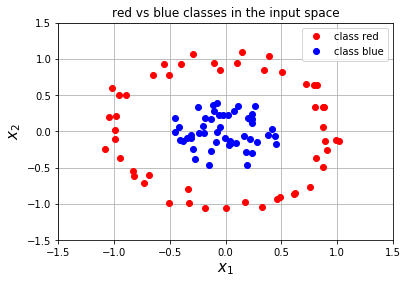

In [55]:
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red vs blue classes in the input space')
plt.show()

In [56]:
# Vectorizing forward prop
# Define the logistic function
def logistic(z): 
    return 1 / (1 + np.exp(-z))

# Define the softmax function
def softmax(z): 
    return np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

# Function to compute the hidden activations
def hidden_activations(X, Wh, bh):
    return logistic(X.dot(Wh) + bh)

# Define output layer feedforward
def output_activations(H, Wo, bo):
    return softmax(H.dot(Wo) + bo)

# Define the neural network function
def nn(X, Wh, bh, Wo, bo): 
    return output_activations(hidden_activations(X, Wh, bh), Wo, bo)

# Define the neural network prediction function that only returns
#  1 or 0 depending on the predicted class
def nn_predict(X, Wh, bh, Wo, bo): 
    return np.around(nn(X, Wh, bh, Wo, bo))

In [57]:
# Vectorizing backward prop - OUTPUT LAYER
# Define the cost function
def cost(Y, T):
    return - np.multiply(T, np.log(Y)).sum()

# Define the error function at the output
def error_output(Y, T):
    return Y - T

# Define the gradient function for the weight parameters at the output layer
def gradient_weight_out(H, Eo): 
    return  H.T.dot(Eo)

# Define the gradient function for the bias parameters at the output layer
def gradient_bias_out(Eo): 
    return  np.sum(Eo, axis=0, keepdims=True)

In [58]:
# Vectorizing backward prop - HIDDEN LAYER
# Define the error function at the hidden layer
def error_hidden(H, Wo, Eo):
    # H * (1-H) * (E . Wo^T)
    return np.multiply(np.multiply(H,(1 - H)), Eo.dot(Wo.T))

# Define the gradient function for the weight parameters at the hidden layer
def gradient_weight_hidden(X, Eh):
    return X.T.dot(Eh)

# Define the gradient function for the bias parameters at the output layer
def gradient_bias_hidden(Eh): 
    return  np.sum(Eh, axis=0, keepdims=True)

In [59]:
# Gradient Checking
# Initialize weights and biases
init_var = 1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var

# Compute the gradients by backpropagation
# Compute the activations of the layers
H = hidden_activations(X, Wh, bh)
Y = output_activations(H, Wo, bo)
# Compute the gradients of the output layer
Eo = error_output(Y, T)
JWo = gradient_weight_out(H, Eo)
Jbo = gradient_bias_out(Eo)
# Compute the gradients of the hidden layer
Eh = error_hidden(H, Wo, Eo)
JWh = gradient_weight_hidden(X, Eh)
Jbh = gradient_bias_hidden(Eh)

In [60]:
# Combine all parameter matrices in a list
params = [Wh, bh, Wo, bo]
# Combine all parameter gradients in a list
grad_params = [JWh, Jbh, JWo, Jbo]

# Set the small change to compute the numerical gradient
eps = 0.0001

# Check each parameter matrix
for p_idx in range(len(params)):
    # Check each parameter in each parameter matrix
    for row in range(params[p_idx].shape[0]):
        for col in range(params[p_idx].shape[1]):
            # Copy the parameter matrix and change the current parameter slightly
            p_matrix_min = params[p_idx].copy()
            p_matrix_min[row,col] -= eps
            p_matrix_plus = params[p_idx].copy()
            p_matrix_plus[row,col] += eps
            # Copy the parameter list, and change the updated parameter matrix
            params_min = params[:]
            params_min[p_idx] = p_matrix_min
            params_plus = params[:]
            params_plus[p_idx] =  p_matrix_plus
            # Compute the numerical gradient
            grad_num = (cost(nn(X, *params_plus), T)-cost(nn(X, *params_min), T))/(2*eps)
            # Raise error if the numerical grade is not close to the backprop gradient
            if not np.isclose(grad_num, grad_params[p_idx][row,col]):
                raise ValueError('Numerical gradient of {:.6f} is not close to the backpropagation gradient of {:.6f}!'.format(float(grad_num), float(grad_params[p_idx][row,col])))
print('No gradient errors found')

No gradient errors found


In [61]:
# Define the update function to update the network parameters over 1 iteration
def backprop_gradients(X, T, Wh, bh, Wo, bo):
    # Compute the output of the network
    # Compute the activations of the layers
    H = hidden_activations(X, Wh, bh)
    Y = output_activations(H, Wo, bo)
    # Compute the gradients of the output layer
    Eo = error_output(Y, T)
    JWo = gradient_weight_out(H, Eo)
    Jbo = gradient_bias_out(Eo)
    # Compute the gradients of the hidden layer
    Eh = error_hidden(H, Wo, Eo)
    JWh = gradient_weight_hidden(X, Eh)
    Jbh = gradient_bias_hidden(Eh)
    return [JWh, Jbh, JWo, Jbo]

def update_velocity(X, T, ls_of_params, Vs, momentum_term, learning_rate):
    # ls_of_params = [Wh, bh, Wo, bo]
    # Js = [JWh, Jbh, JWo, Jbo]
    Js = backprop_gradients(X, T, *ls_of_params)
    return [momentum_term * V - learning_rate * J for V,J in zip(Vs, Js)]

def update_params(ls_of_params, Vs):
    # ls_of_params = [Wh, bh, Wo, bo]
    # Vs = [VWh, Vbh, VWo, Vbo]
    return [P + V for P,V in zip(ls_of_params, Vs)]

In [62]:
# Run backpropagation
# Initialize weights and biases
init_var = 0.1
# Initialize hidden layer parameters
bh = np.random.randn(1, 3) * init_var
Wh = np.random.randn(2, 3) * init_var
# Initialize output layer parameters
bo = np.random.randn(1, 2) * init_var
Wo = np.random.randn(3, 2) * init_var
# Parameters are already initilized randomly with the gradient checking
# Set the learning rate
learning_rate = 0.02
momentum_term = 0.9

# define the velocities Vs = [VWh, Vbh, VWo, Vbo]
Vs = [np.zeros_like(M) for M in [Wh, bh, Wo, bo]]

# Start the gradient descent updates and plot the iterations
nb_of_iterations = 300  # number of gradient descent updates
lr_update = learning_rate / nb_of_iterations # learning rate update rule
ls_costs = [cost(nn(X, Wh, bh, Wo, bo), T)]  # list of cost over the iterations
for i in range(nb_of_iterations):
    # Update the velocities and the parameters
    Vs = update_velocity(X, T, [Wh, bh, Wo, bo], Vs, momentum_term, learning_rate)
    Wh, bh, Wo, bo = update_params([Wh, bh, Wo, bo], Vs)
    ls_costs.append(cost(nn(X, Wh, bh, Wo, bo), T))

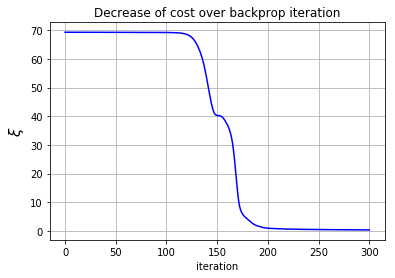

In [63]:
# Plot the cost over the iterations
plt.plot(ls_costs, 'b-')
plt.xlabel('iteration')
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Decrease of cost over backprop iteration')
plt.grid()
plt.show()

In [64]:
# Plot the resulting decision boundary
# Generate a grid over the input space to plot the color of the
#  classification at that grid point
nb_of_xs = 200
xs1 = np.linspace(-2, 2, num=nb_of_xs)
xs2 = np.linspace(-2, 2, num=nb_of_xs)
xx, yy = np.meshgrid(xs1, xs2) # create the grid
# Initialize and fill the classification plane
classification_plane = np.zeros((nb_of_xs, nb_of_xs))
for i in range(nb_of_xs):
    for j in range(nb_of_xs):
        pred = nn_predict(np.asmatrix([xx[i,j], yy[i,j]]), Wh, bh, Wo, bo)
        classification_plane[i,j] = pred[0,0]
# Create a color map to show the classification colors of each grid point
cmap = ListedColormap([
        colorConverter.to_rgba('b', alpha=0.30),
        colorConverter.to_rgba('r', alpha=0.30)])

# Plot the classification plane with decision boundary and input samples
plt.contourf(xx, yy, classification_plane, cmap=cmap)
# Plot both classes on the x1, x2 plane
plt.plot(x_red[:,0], x_red[:,1], 'ro', label='class red')
plt.plot(x_blue[:,0], x_blue[:,1], 'bo', label='class blue')
plt.grid()
plt.legend(loc=1)
plt.xlabel('$x_1$', fontsize=15)
plt.ylabel('$x_2$', fontsize=15)
plt.axis([-1.5, 1.5, -1.5, 1.5])
plt.title('red vs blue classification boundary')
plt.show()

TypeError: sum() got an unexpected keyword argument 'keepdims'

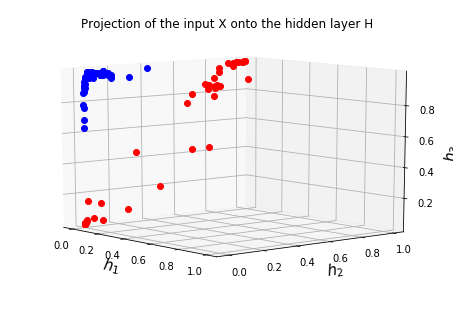

In [53]:
# Plot the projection of the input onto the hidden layer

# Define the projections of the blue and red classes
H_blue = hidden_activations(x_blue, Wh, bh)
H_red = hidden_activations(x_red, Wh, bh)
# Plot the error surface
fig = plt.figure()
ax = Axes3D(fig)
ax.plot(np.ravel(H_blue[:,0]), np.ravel(H_blue[:,1]), np.ravel(H_blue[:,2]), 'bo')
ax.plot(np.ravel(H_red[:,0]), np.ravel(H_red[:,1]), np.ravel(H_red[:,2]), 'ro')
ax.set_xlabel('$h_1$', fontsize=15)
ax.set_ylabel('$h_2$', fontsize=15)
ax.set_zlabel('$h_3$', fontsize=15)
ax.view_init(elev=10, azim=-40)
plt.title('Projection of the input X onto the hidden layer H')
plt.grid()
plt.show()